# AMV Historical Data

In [1]:
# 1. Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
import math

In [2]:
# 2. Read the CSV file
data = pd.read_csv('AMV Historical Data.csv')

# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)

# Áp dụng hàm chuyển đổi cho cột "Vol."
data["Vol."] = data["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
data["Change %"] = data["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
data['Price'] = data['Price'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

data

df1=data.reset_index()['Price']

In [3]:
data

,Date,Price,Open,High,Low,Vol.,Change %
0,05/31/2024,3700.0,3600.0,3800.0,3600.0,1440000,0.0278
1,05/30/2024,3600.0,3600.0,3800.0,3500.0,3230000,0.0286
2,05/29/2024,3500.0,3500.0,3600.0,3500.0,522679,0.0000
3,05/28/2024,3500.0,3500.0,3600.0,3500.0,452540,0.0000
4,05/27/2024,3500.0,3500.0,3600.0,3500.0,660470,0.0000
...,...,...,...,...,...,...,...
1308,03/07/2019,14144.0,14594.0,14594.0,14144.0,28810,-0.0308
1309,03/06/2019,14594.0,14414.0,14684.0,14414.0,17250,0.0125
1310,03/05/2019,14414.0,14865.0,15045.0,14414.0,48800,-0.0303
1311,03/04/2019,14865.0,15180.0,15180.0,14865.0,19010,-0.0236


In [4]:
df1

0        3700.0
1        3600.0
2        3500.0
3        3500.0
4        3500.0
         ...   
1308    14144.0
1309    14594.0
1310    14414.0
1311    14865.0
1312    15225.0
Name: Price, Length: 1313, dtype: float64

In [5]:
# 3. Scaling data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [6]:
# 4. Splitting data into train and test sets
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [7]:
# 5. Create dataset function
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [8]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [9]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [10]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step, 1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
# 9. Fit the model with train data
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0592 - val_loss: 0.0266
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0109 - val_loss: 0.0040
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0051 - val_loss: 0.0076
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0045 - val_loss: 0.0051
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0056 - val_loss: 0.0039
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0035 - val_loss: 0.0042
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0037 - val_loss: 0.0041
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0046 - val_loss: 0.0031
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0024 - val_loss: 0.0034
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

In [12]:
# 10. Predict test data
y_pred=model.predict(X_test)

y_pred_new = scaler.inverse_transform(y_pred.reshape(1, -1))
y_test_new = scaler.inverse_transform(np.array([y_test], dtype=np.float32))

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


In [13]:
# 11. Calculate RMSE, MAPE, MSLE

test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 811.03235
MAPE trên tập test là: 3.755256161093712 %
MSLE trên tập test là: 0.0027994227


In [14]:
# 12. Function to predict future values
def predict_future_days(model, test_data, scaler, n_days):
    x_input = test_data[-time_step:].reshape(1, -1)
    temp_input = list(x_input[0])

    lst_output = []
    i = 0
    while i < n_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape(1, -1)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    
    return lst_output

In [15]:
# 13. Predict next 30 days, 60 days, 90 days
lst_output_30_days = predict_future_days(model, test_data, scaler, 30)
predicted_30_days = scaler.inverse_transform(np.array(lst_output_30_days).reshape(-1, 1))


lst_output_60_days = predict_future_days(model, test_data, scaler, 60)
predicted_60_days = scaler.inverse_transform(np.array(lst_output_60_days).reshape(-1, 1))


lst_output_90_days = predict_future_days(model, test_data, scaler, 90)
predicted_90_days = scaler.inverse_transform(np.array(lst_output_90_days).reshape(-1, 1))

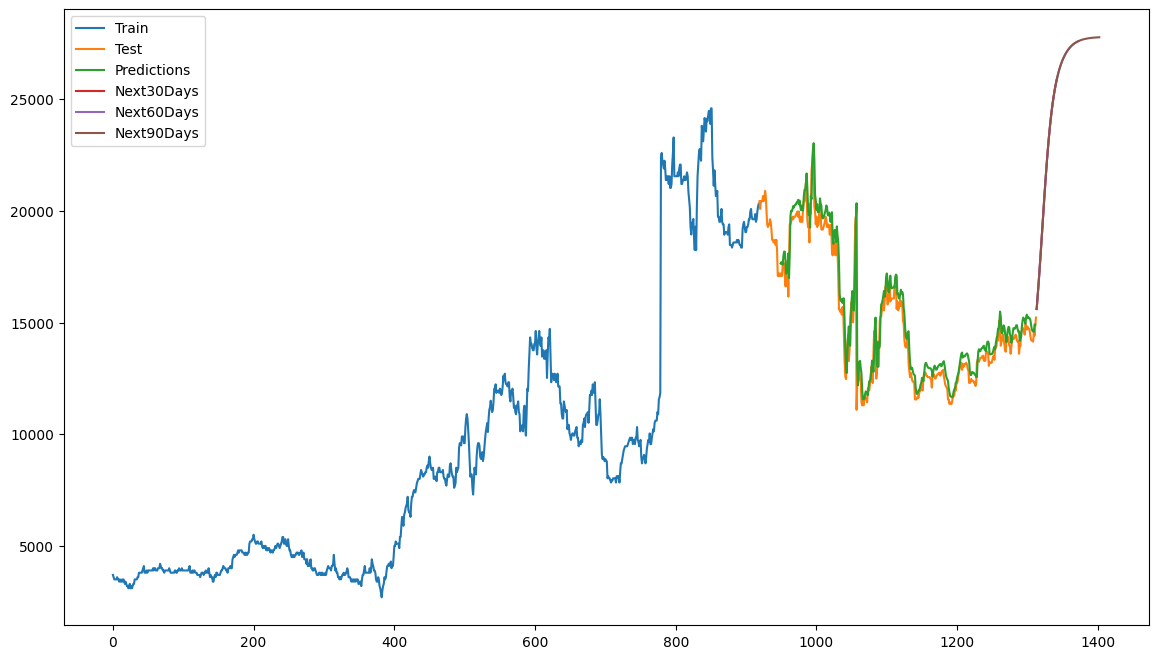

In [16]:
# 14. Plotting
plt.figure(figsize=(14, 8))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

predicted_index = pd.RangeIndex(start=train_size + time_step, stop=train_size + time_step + len(y_pred), step=1)
plt.plot(predicted_index, scaler.inverse_transform(y_pred), label='Predictions')

future_30_days_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 30, step=1)
plt.plot(future_30_days_index, predicted_30_days, label='Next30Days')

future_60_days_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 60, step=1)
plt.plot(future_60_days_index, predicted_60_days, label='Next60Days')

future_90_days_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 90, step=1)
plt.plot(future_90_days_index, predicted_90_days, label='Next90Days')

plt.legend()
plt.show()

# DHT Historical Data

In [17]:
# 2. Read the CSV file
data = pd.read_csv('DHT Historical Data.csv')

# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)

# Áp dụng hàm chuyển đổi cho cột "Vol."
data["Vol."] = data["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
data["Change %"] = data["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
data['Price'] = data['Price'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

data

df1=data.reset_index()['Price']

In [18]:
data

,Date,Price,Open,High,Low,Vol.,Change %
0,05/31/2024,40400.0,39300.0,41000.0,38900.0,154530,0.0280
1,05/30/2024,39300.0,38800.0,39800.0,38500.0,76570,-0.0051
2,05/29/2024,39500.0,39900.0,39900.0,38300.0,107350,0.0051
3,05/28/2024,39300.0,38600.0,39500.0,38200.0,61630,0.0181
4,05/27/2024,38600.0,35200.0,39900.0,35200.0,133260,0.0604
...,...,...,...,...,...,...,...
1307,03/07/2019,11589.7,11842.2,11842.2,11224.9,240150,0.0024
1308,03/06/2019,11561.6,11309.1,11589.7,11309.1,292910,0.0198
1309,03/05/2019,11337.1,11224.9,11365.2,10888.1,308000,0.0100
1310,03/04/2019,11224.9,11056.5,11477.4,11056.5,296000,0.0336


In [19]:
df1

0       40400.0
1       39300.0
2       39500.0
3       39300.0
4       38600.0
         ...   
1307    11589.7
1308    11561.6
1309    11337.1
1310    11224.9
1311    10860.1
Name: Price, Length: 1312, dtype: float64

In [20]:
# 3. Scaling data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [21]:
# 4. Splitting data into train and test sets
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [22]:
# 5. Create dataset function
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [23]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [24]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [25]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step, 1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
# 9. Fit the model with train data
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0244 - val_loss: 0.0017
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0043 - val_loss: 0.0011
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0023 - val_loss: 9.4053e-04
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0013 - val_loss: 8.4971e-04
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0013 - val_loss: 8.2742e-04
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0013 - val_loss: 9.4325e-04
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9.8964e-04 - val_loss: 7.5154e-04
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0011 - val_loss: 7.6908e-04
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0011 - val_loss: 8.9874e-04
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0012 - val_loss: 7.2889e-04
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 9.5023e-04 - val_loss: 8.8454e-04
Epoch 12

In [27]:
# 10.  Predict test data
y_pred=model.predict(X_test)

y_pred_new = scaler.inverse_transform(y_pred.reshape(1, -1))
y_test_new = scaler.inverse_transform(np.array([y_test], dtype=np.float32))

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


In [28]:
# 11. Calculate RMSE, MAPE, MSLE

test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 498.26758
MAPE trên tập test là: 2.5032294914126396 %
MSLE trên tập test là: 0.0011565847


In [29]:
# 12. Function to predict future values
def predict_future_days(model, test_data, scaler, n_days):
    x_input = test_data[-time_step:].reshape(1, -1)
    temp_input = list(x_input[0])

    lst_output = []
    i = 0
    while i < n_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape(1, -1)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    
    return lst_output

In [30]:
# 13. Predict next 30 days, 60 days, 90 days
lst_output_30_days = predict_future_days(model, test_data, scaler, 30)
predicted_30_days = scaler.inverse_transform(np.array(lst_output_30_days).reshape(-1, 1))


lst_output_60_days = predict_future_days(model, test_data, scaler, 60)
predicted_60_days = scaler.inverse_transform(np.array(lst_output_60_days).reshape(-1, 1))


lst_output_90_days = predict_future_days(model, test_data, scaler, 90)
predicted_90_days = scaler.inverse_transform(np.array(lst_output_90_days).reshape(-1, 1))

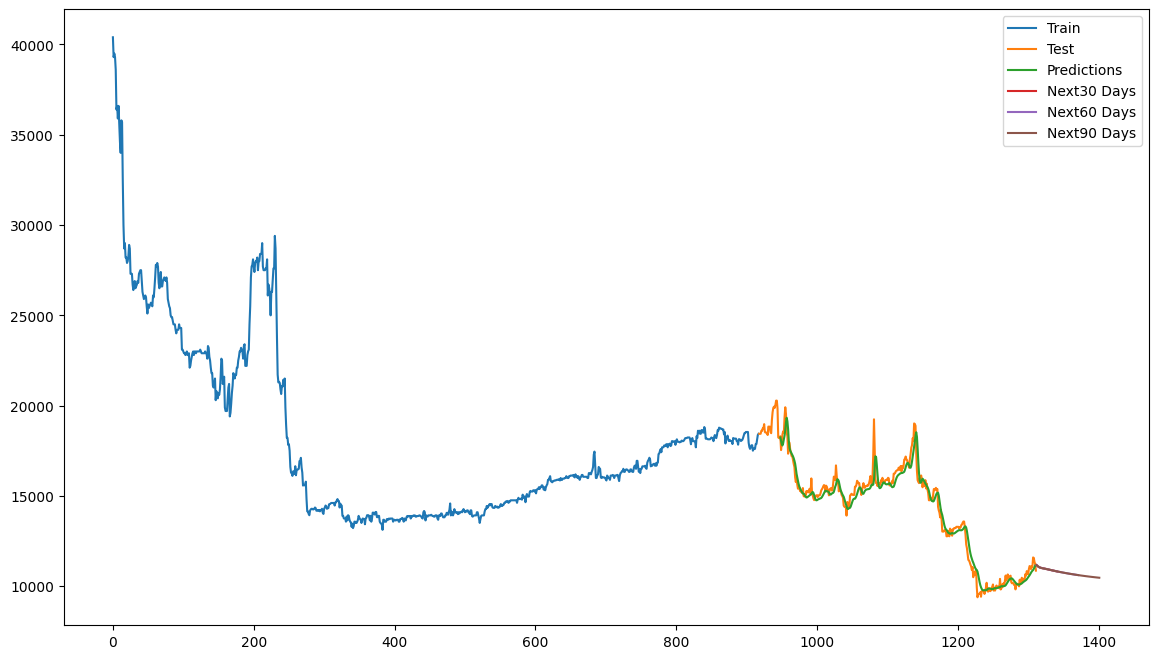

In [31]:
# 14. Plotting
plt.figure(figsize=(14, 8))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

predicted_index = pd.RangeIndex(start=train_size + time_step, stop=train_size + time_step + len(y_pred), step=1)
plt.plot(predicted_index, scaler.inverse_transform(y_pred), label='Predictions')

future_30_days_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 30, step=1)
plt.plot(future_30_days_index, predicted_30_days, label='Next30 Days')

future_60_days_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 60, step=1)
plt.plot(future_60_days_index, predicted_60_days, label='Next60 Days')

future_90_days_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 90, step=1)
plt.plot(future_90_days_index, predicted_90_days, label='Next90 Days')

plt.legend()
plt.show()

# DP3 Historical Data

In [32]:
# 2. Read the CSV file
data = pd.read_csv('DP3 Historical Data.csv')

# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
data["Change %"] = data["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
data['Price'] = data['Price'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

data

df1=data.reset_index()['Price']

In [33]:
data

,Date,Price,Open,High,Low,Vol.,Change %
0,05/31/2024,61600.0,61500.0,61700.0,61500.0,10.51K,0.0016
1,05/30/2024,61500.0,61000.0,61500.0,60700.0,5.11K,0.0082
2,05/29/2024,61000.0,62000.0,62000.0,61000.0,7.30K,0.0000
3,05/28/2024,61000.0,61000.0,61800.0,60900.0,7.90K,0.0016
4,05/27/2024,60900.0,61700.0,61700.0,60900.0,12.67K,-0.0016
...,...,...,...,...,...,...,...
1132,03/07/2019,76300.0,75000.0,76900.0,74700.0,11.57K,0.0214
1133,03/06/2019,74700.0,74100.0,75000.0,74000.0,3.81K,0.0040
1134,03/05/2019,74400.0,75000.0,75000.0,74000.0,7.33K,-0.0067
1135,03/04/2019,74900.0,73800.0,75200.0,73800.0,8.34K,0.0149


In [34]:
df1

0       61600.0
1       61500.0
2       61000.0
3       61000.0
4       60900.0
         ...   
1132    76300.0
1133    74700.0
1134    74400.0
1135    74900.0
1136    73800.0
Name: Price, Length: 1137, dtype: float64

In [35]:
# 3. Scaling data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [36]:
# 4. Splitting data into train and test sets
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [37]:
# 5. Create dataset function
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [38]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [39]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [40]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step, 1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [41]:
# 9. Fit the model with train data
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.1354 - val_loss: 0.0076
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0146 - val_loss: 0.0052
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0089 - val_loss: 0.0018
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0074 - val_loss: 0.0014
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0071 - val_loss: 0.0015
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0068 - val_loss: 0.0013
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0056 - val_loss: 0.0012
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0068 - val_loss: 0.0011
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0046 - val_loss: 0.0011
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0051 - val_loss: 0.0011
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0053 - val_loss: 9.7171e-04
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/

In [42]:
# 10. Predict test data
y_pred=model.predict(X_test)

y_pred_new = scaler.inverse_transform(y_pred.reshape(1, -1))
y_test_new = scaler.inverse_transform(np.array([y_test], dtype=np.float32))

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


In [43]:
# 11. Calculate RMSE, MAPE, MSLE

test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 1821.177
MAPE trên tập test là: 1.727844774723053 %
MSLE trên tập test là: 0.00065331446


In [44]:
# 12. Function to predict future values
def predict_future_days(model, test_data, scaler, n_days):
    x_input = test_data[-time_step:].reshape(1, -1)
    temp_input = list(x_input[0])

    lst_output = []
    i = 0
    while i < n_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape(1, -1)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    
    return lst_output

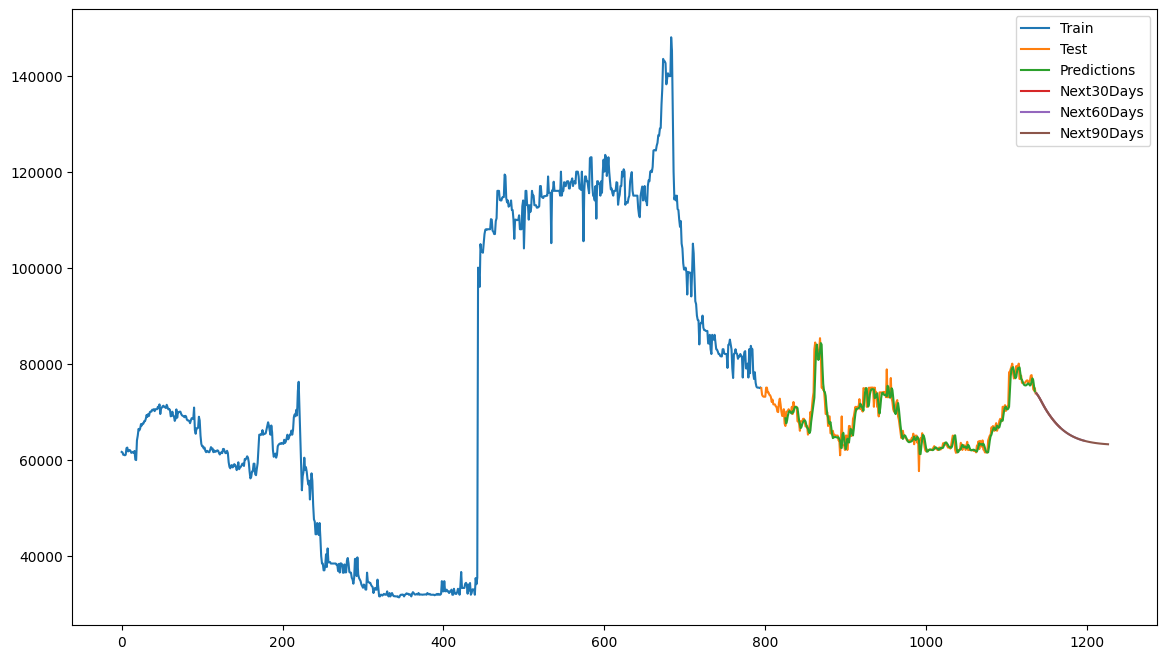

In [45]:
# 13. Predict next 30 days, 60 days, 90 days
lst_output_30_days = predict_future_days(model, test_data, scaler, 30)
predicted_30_days = scaler.inverse_transform(np.array(lst_output_30_days).reshape(-1, 1))


lst_output_60_days = predict_future_days(model, test_data, scaler, 60)
predicted_60_days = scaler.inverse_transform(np.array(lst_output_60_days).reshape(-1, 1))


lst_output_90_days = predict_future_days(model, test_data, scaler, 90)
predicted_90_days = scaler.inverse_transform(np.array(lst_output_90_days).reshape(-1, 1))

# 14. Plotting
plt.figure(figsize=(14, 8))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

predicted_index = pd.RangeIndex(start=train_size + time_step, stop=train_size + time_step + len(y_pred), step=1)
plt.plot(predicted_index, scaler.inverse_transform(y_pred), label='Predictions')

future_30_days_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 30, step=1)
plt.plot(future_30_days_index, predicted_30_days, label='Next30Days')

future_60_days_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 60, step=1)
plt.plot(future_60_days_index, predicted_60_days, label='Next60Days')

future_90_days_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 90, step=1)
plt.plot(future_90_days_index, predicted_90_days, label='Next90Days')

plt.legend()
plt.show()